# Options and Black-Scholes Model

### This notebook demostrated how to calibrate Black-Scholes model with real-world data

## 1. Price an option

__Consider a call option__
$$ dS_t = \mu S_t dt+\sigma S_t dW_t $$
$$ S_t = S_0 \cdot exp(\mu t + \sigma W_t) $$

__Denote $F$ as the payoff at expiration $T$__
$$ F_t = B_t \cdot E_Q [B{_T^{-1}} F|\mathcal{F}_t]$$

__With Black-Scholes we explicitly have $F_t$ :__
$$f(t,S_t) = S_t \Phi(d_{+})-K \cdot exp(-r\tau) \Phi(d_{-})$$
$$d_{\pm} = \frac{1}{\sigma \sqrt{\tau}} ln (\frac{S_t}{K})+(r \pm \frac{\sigma^2}{2})\frac{\sqrt{\tau}}{\sigma}$$

__With Put-Call parity: __
$$ C(t) -P(t) = S_t - B{_T^{-1}}K$$

__Let's find the $\mu, \sigma,r$, and other parameters!__

* Prepare the tools

In [2]:
import numpy as np #Handle math objects like vectors and matrixs
from scipy.stats import norm # Normal cdf is used
import pandas as pd #Contains data from yahoo
import matplotlib.pyplot as plt # Seeing is believing! --Thrall
from datetime import datetime # Very usefull when you need to operate on date
from datetime import timedelta # Very usefull when you need to operate on date
from yahoo_finance import Share # API from Yahoo to fetch data
%matplotlib inline

* Choose a stock.

In [329]:
equity = Share('SPY')

Here equity is an object instance with a lots of methods to extract data from yahoo finance

In [330]:
i = datetime.now()
j = i - timedelta(days=365*5)

currentDate = "%s-%s-%s"%(i.year,i.month,i.day)
startDate = "%s-%s-%s"%(j.year,j.month,j.day)

* Fetch historical data

In [331]:
data = equity.get_historical(startDate,currentDate)

_data_ is a list of dictionaries which contains infos more than just price. Take a look.

In [332]:
data[0:3]

[{'Adj_Close': '233.619995',
  'Close': '233.619995',
  'Date': '2017-03-27',
  'High': '233.919998',
  'Low': '231.610001',
  'Open': '231.929993',
  'Symbol': 'SPY',
  'Volume': '86296100'},
 {'Adj_Close': '233.860001',
  'Close': '233.860001',
  'Date': '2017-03-24',
  'High': '235.039993',
  'Low': '232.960007',
  'Open': '234.380005',
  'Symbol': 'SPY',
  'Volume': '107532300'},
 {'Adj_Close': '234.029999',
  'Close': '234.029999',
  'Date': '2017-03-23',
  'High': '235.339996',
  'Low': '233.600006',
  'Open': '234.279999',
  'Symbol': 'SPY',
  'Volume': '100410300'}]

_data_ is very well organized. Pandas.DataFrame is the perfect tool to convert this list into a table.

In [333]:
df = pd.DataFrame(data)
df.index = df.Date
df.drop('Date',1,inplace = True)
# df.set_value('2017-03-27',['Adj_Close','Close','High','Low','Open','Symbol','Volume'],[4.60,4.60,4.65,4.51,4.55,'RAD',8040000])
df.sort_index(inplace = True) # ,ascending = False
df.head()

,Adj_Close,Close,High,Low,Open,Symbol,Volume
Date,,,,,,,
2012-03-29,126.515834,140.229996,140.490005,139.089996,139.639999,SPY,164963700
2012-03-30,127.039113,140.809998,141.050003,140.050003,140.919998,SPY,135486800
2012-04-02,127.968381,141.839996,142.210007,140.360001,140.639999,SPY,151741100
2012-04-03,127.445102,141.259995,141.880005,140.429993,141.639999,SPY,155806700
2012-04-04,126.182024,139.860001,140.339996,139.339996,140.220001,SPY,146896000


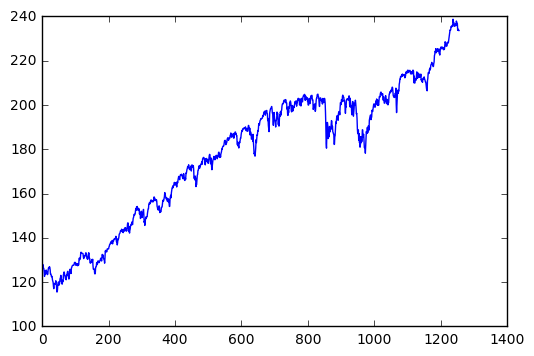

In [334]:
plt.plot(df.Adj_Close.values)

__Unfortunely, Yahoo sent us the data as strings! (WHY?!!?)__


In [335]:
type(df.Adj_Close.values[1])

str

Convert strings to numerics:

In [336]:
numCol = ['Adj_Close','Close','High','Low','Open','Volume']

for col in numCol:
    df[col] = pd.to_numeric(df[col])

In [337]:
type(df.Adj_Close.values[1])

numpy.float64

Compute the log return

In [338]:
df['logReturn'] = np.log(1+df.Adj_Close.diff(1)/df.Adj_Close)
df.fillna(0,inplace = True)

In [339]:
mu = np.mean(df[['logReturn']].values)*252
sigma = np.sqrt(np.var(df[['logReturn']].values)*252)
print(mu,sigma)

0.106800355369 0.127439338231


LIBOR is 1.16% and other parameters

In [560]:
r = 0.0116
# expires at July 17
tau = 116/252
K = 235
S = df['Adj_Close'].values[-1]

* Write a Black-Scholes function

In [569]:
def BS(vec):
    r,sigma,tau,K,S = vec
    B = np.exp(r*tau)
    dp = 1/(sigma*np.sqrt(tau))*np.log(S/K)+(r+(sigma**2)/2)*(np.sqrt(tau)/sigma)
    dm = dp - sigma*np.sqrt(tau)
    call = S*norm.cdf(dp)-(K/B)*norm.cdf(dm)
    put = call - (S-(K/B))
    delta = norm.cdf(dp)
    return(call,put,delta)

In [582]:
options = [{"Type":"Call",
          "Strike":232.5,
          "Bid":1.40,
          "Ask":1.48},
         {"Type":"Call",
          "Strike":233,
          "Bid":1.08,
          "Ask":1.11},
         {"Type":"Call",
          "Strike":233.5,
          "Bid":0.76,
          "Ask":0.78},
          {"Type":"Put",
          "Strike":232.5,
          "Bid":0.31,
          "Ask":0.32},
         {"Type":"Put",
          "Strike":233,
          "Bid":0.44,
          "Ask":0.45},
         {"Type":"Put",
          "Strike":233.5,
          "Bid":0.62,
          "Ask":0.64}]
options_df = pd.DataFrame(options)
options_df['Date']  = '2017-03-27'
options_df = options_df[['Date','Type','Strike','Bid','Ask']]
options_df['Mid'] = (options_df['Bid']+options_df['Ask'])/2
options_df

,Date,Type,Strike,Bid,Ask,Mid
0,2017-03-27,Call,232.5,1.40,1.48,1.440
1,2017-03-27,Call,233.0,1.08,1.11,1.095
2,2017-03-27,Call,233.5,0.76,0.78,0.770
3,2017-03-27,Put,232.5,0.31,0.32,0.315
4,2017-03-27,Put,233.0,0.44,0.45,0.445
5,2017-03-27,Put,233.5,0.62,0.64,0.630


In [563]:
#r,sigma,tau,K,S = vec

In [570]:
call,put,delta = BS([r,sigma,tau,K,S])

print(call,put,delta)

7.99407218052 8.12259601331 0.514705965864


## 2. Implied Vol and Vol Smile

Here we solve for the implied vol numerically, formally solving this:

$$ min_\sigma ||BS(\sigma)-Call^{*}||{_2^2}$$

Where $Call^*$ is the vector of actual call prices.

* Write a line-search function to find Implied Vol Numerically so that we can call it to get the vol smile later

In [571]:
def IV(vec):
    r,tau,K,S,call = vec
    error = []
    sigmaList = (pd.Series(range(0,4000))+1)/2000 #search from 0 to 2.0
    for sigma in sigmaList:
        error.append((BS([r,sigma,tau,K,S])[0]-call)**2)
    loc = np.argmin(error)
    return(sigmaList[loc])

In [581]:
IV([r,tau,K,S,5.5])*100

8.7999999999999989

This result is __not close__ to the one provided by Optionshouse.com (12.74%) or fintools.com (10.94%)

Now we loop through an options chain to get vol smile:

In [573]:
strikeList = pd.Series(range(210,260,5)).tolist()
callList = [25.48,20.94,16.58,12.47,8.74,5.50,2.97,1.32,0.50,0.185]

n = len(callList)

In [574]:
volList = list(map(lambda ind: IV([r,tau,strikeList[ind],S,callList[ind]]), list(range(n))))

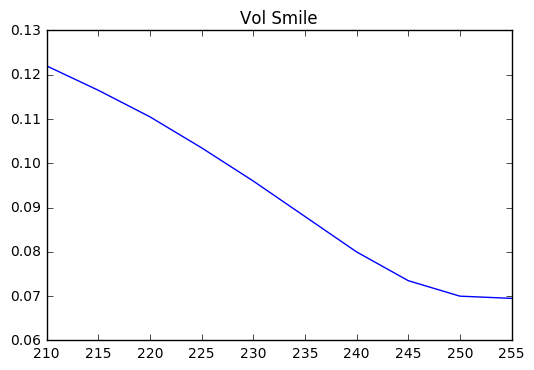

In [580]:
plt.plot(strikeList,volList)
plt.savefig('SPY_vol_smile_03-27.png')
plt.title("Vol Smile")